In [ ]:
!nvidia-smi

Wed Aug 19 23:43:28 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.57       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   54C    P8    10W /  70W |      0MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
#!git clone https://github.com/NVIDIA/apex /apex
#!pip install -v --no-cache-dir --global-option="--cpp_ext" --global-option="--cuda_ext" /apex/.

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
!ls "/content/gdrive/My Drive/lab/SSD/"
gdrive_dir = "/content/gdrive/My Drive/lab/SSD/"

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive
models	train-eval_2.ipynb  train-eval-sddLite.ipynb  trainval.zip


In [ ]:
!unzip -q "/content/gdrive/My Drive/lab/SSD/trainval.zip" -d /content
#!cp /content/gdrive/My\ Drive/lab/SSD/datasets/*.json /content/datasets
!git clone https://github.com/ncthuan/single-shot-detection-pytorch
!cp single-shot-detection-pytorch/*.py .
!pip install albumentations==0.4.6 -q

Cloning into 'single-shot-detection-pytorch'...
remote: Enumerating objects: 151, done.
remote: Counting objects: 100% (151/151), done.
remote: Compressing objects: 100% (107/107), done.
remote: Total 151 (delta 89), reused 100 (delta 42), pack-reused 0
Receiving objects: 100% (151/151), 142.05 KiB | 10.15 MiB/s, done.
Resolving deltas: 100% (89/89), done.
     |████████████████████████████████| 122kB 5.7MB/s 
     |████████████████████████████████| 952kB 18.5MB/s 


In [ ]:
import os
import time
import torch
import torch.cuda as cuda
import seaborn as sns
import numpy as np
from torch.utils.data import DataLoader
from dataset import VOCDataset, collate_fn
from ssdLite import SSDLite
from loss import MultiBoxLoss
from utils import create_data_lists, clip_gradient, save_checkpoint
from eval_detection_voc import eval_detection_voc
device = torch.device("cuda" if cuda.is_available() else "cpu") 

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Load dataset

In [ ]:
from utils import create_data_lists
voc07_path = os.path.join('datasets/', 'VOC2007/')
voc12_path = os.path.join('datasets/', 'VOC2012/')
create_data_lists(voc07_path, voc12_path, output_folder='datasets/')


There are 16551 training images. Files have been saved to output_folder: datasets/.

There are 4952 validation images. Files have been saved to output_folder: datasets/.


In [ ]:
!ls datasets/

label_map.json	   TRAIN_objects.json  VAL_objects.json  VOC2012
TRAIN_images.json  VAL_images.json     VOC2007


In [ ]:
torch.manual_seed(42)
trainset = VOCDataset(data_folder='datasets/', json_files=('TRAIN_images.json', 'TRAIN_objects.json'), augment=True, img_size=320)
valset = VOCDataset(data_folder='datasets/', json_files=('VAL_images.json', 'VAL_objects.json'), img_size=320)

dataloaders = dict(
    train = DataLoader(trainset, batch_size=32, collate_fn=collate_fn, shuffle=True, num_workers=4),
    val = DataLoader(valset, batch_size=32, collate_fn=collate_fn, shuffle=False, num_workers=4),
)

## Train model

In [ ]:
checkpoint_path = gdrive_dir+'models/checkpoint_ssd_lite.pt'
checkpoint = torch.load(checkpoint_path) # None

if checkpoint:
    ssd_lite = checkpoint['model']
    optimizer = checkpoint['optimizer']
else:
    ssd_lite = SSDLite(n_classes=21).to(device)
    optimizer = torch.optim.Adam(ssd_lite.parameters(), lr=1e-3, weight_decay=5e-4)

loss_func = MultiBoxLoss(priors_cxcy=ssd_lite.get_prior_boxes(), threshold=0.5, neg_pos_ratio=3, alpha=1.)

#exp_lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.98, last_epoch=-1)

grad_clip = None

In [ ]:
def train_epoch(model, trainset_loader, loss_func, optimizer, epoch_id):
    model.train()
    train_loss = 0
    for step, (imgs, boxes, labels,_) in enumerate(trainset_loader):
        # move input data to GPU
        imgs = imgs.to(device)
        boxes = [b.to(device) for b in boxes]
        labels = [l.to(device) for l in labels]
        
        # forward
        predicted_offsets, predicted_scores = model(imgs)
        loss = loss_func(predicted_offsets, predicted_scores, boxes, labels)
        
        # backward & optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if epoch_id == 1 and step % 50 == 0:
            print(f'Epoch 1 - step {step}: train_loss: {loss.item():.4f}')
        
        train_loss += loss.item()
        
    return round(train_loss/len(trainset_loader), 4)

def eval_epoch(model, valset_loader, loss_func):
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for step, (imgs, boxes, labels,_) in enumerate(valset_loader):
            imgs = imgs.to(device)
            boxes = [b.to(device) for b in boxes]
            labels = [l.to(device) for l in labels]
            
            predicted_offsets, predicted_scores = model(imgs)
            loss = loss_func(predicted_offsets, predicted_scores, boxes, labels)
            val_loss += loss.item()

    return round(val_loss/len(valset_loader), 4)


def train_model(model, dataloaders, optimizer, loss_func, n_epoch=1, checkpoint=None):
    last_epoch = 0
    if checkpoint:
        last_epoch = checkpoint['epoch']

    train_loss_hist, val_loss_hist = [], []
    for epoch_id in range(last_epoch+1, last_epoch+n_epoch+1):
        start_time = time.time()
        train_loss = train_epoch(model, dataloaders['train'], loss_func, optimizer, epoch_id)
        training_time = round(time.time() - start_time)
        
        save_checkpoint(epoch_id, model, optimizer, checkpoint_path)
        
        # eval val_loss every epoch
        start_time = time.time()
        val_loss = eval_epoch(model, dataloaders['val'], loss_func) # if epoch_id % 5 == 0 else 'N/A'
        val_time = round(time.time() - start_time)
        
        train_loss_hist.append(train_loss)
        val_loss_hist.append(val_loss)
        
        print(f'Epoch {epoch_id} - train/val_time: {training_time}s | {val_time}s - train_loss: {train_loss} - val_loss: {val_loss}')
        
    return train_loss_hist, val_loss_hist

In [ ]:
train_hist, val_hist = train_model(ssd_lite, dataloaders, optimizer, loss_func, n_epoch=30)

Epoch 1 - step 0: train_loss: 64.0948
Epoch 1 - step 50: train_loss: 7.7020
Epoch 1 - step 100: train_loss: 5.9452
Epoch 1 - step 150: train_loss: 5.8432
Epoch 1 - step 200: train_loss: 5.5743
Epoch 1 - step 250: train_loss: 5.5847
Epoch 1 - step 300: train_loss: 5.5368
Epoch 1 - step 350: train_loss: 5.2413
Epoch 1 - step 400: train_loss: 5.6414
Epoch 1 - step 450: train_loss: 5.3682
Epoch 1 - step 500: train_loss: 5.2777
Epoch 1 - train/val_time: 552s | 47s - train_loss: 7.0 - val_loss: 5.1774
Epoch 2 - train/val_time: 539s | 46s - train_loss: 5.2154 - val_loss: 4.9256
Epoch 3 - train/val_time: 544s | 46s - train_loss: 4.9787 - val_loss: 4.7643
Epoch 4 - train/val_time: 548s | 46s - train_loss: 4.7466 - val_loss: 4.5668
Epoch 5 - train/val_time: 554s | 46s - train_loss: 4.5908 - val_loss: 4.3177
Epoch 6 - train/val_time: 545s | 47s - train_loss: 4.4854 - val_loss: 4.3335
Epoch 7 - train/val_time: 551s | 46s - train_loss: 4.3789 - val_loss: 4.2981
Epoch 8 - train/val_time: 545s | 46s 

In [ ]:
train_hist, val_hist = train_model(ssd_lite, dataloaders, optimizer, loss_func, n_epoch=15, checkpoint=checkpoint)

Epoch 31 - train/val_time: 661s | 60s - train_loss: 3.4602 - val_loss: 3.3162
Epoch 32 - train/val_time: 652s | 59s - train_loss: 3.448 - val_loss: 3.2334
Epoch 33 - train/val_time: 650s | 58s - train_loss: 3.4409 - val_loss: 3.2529
Epoch 34 - train/val_time: 655s | 58s - train_loss: 3.4281 - val_loss: 3.2061
Epoch 35 - train/val_time: 649s | 57s - train_loss: 3.4062 - val_loss: 3.2525
Epoch 36 - train/val_time: 662s | 59s - train_loss: 3.4049 - val_loss: 3.2519
Epoch 37 - train/val_time: 656s | 57s - train_loss: 3.3822 - val_loss: 3.3189
Epoch 38 - train/val_time: 644s | 59s - train_loss: 3.3754 - val_loss: 3.2906
Epoch 39 - train/val_time: 660s | 59s - train_loss: 3.372 - val_loss: 3.2848
Epoch 40 - train/val_time: 652s | 58s - train_loss: 3.3531 - val_loss: 3.2044
Epoch 41 - train/val_time: 657s | 58s - train_loss: 3.3524 - val_loss: 3.1671
Epoch 42 - train/val_time: 647s | 58s - train_loss: 3.3332 - val_loss: 3.3031
Epoch 43 - train/val_time: 647s | 59s - train_loss: 3.3326 - val_l

In [ ]:
# adjust learning rate
for param_group in optimizer.param_groups: param_group['lr'] = 0.6e-3

train_hist, val_hist = train_model(ssd_lite, dataloaders, optimizer, loss_func, n_epoch=25, checkpoint=checkpoint)

Epoch 46 - train/val_time: 645s | 58s - train_loss: 3.1669 - val_loss: 2.9832
Epoch 47 - train/val_time: 631s | 56s - train_loss: 3.1444 - val_loss: 2.986
Epoch 48 - train/val_time: 611s | 56s - train_loss: 3.1296 - val_loss: 2.9922
Epoch 49 - train/val_time: 624s | 56s - train_loss: 3.1173 - val_loss: 2.9738
Epoch 50 - train/val_time: 609s | 55s - train_loss: 3.1206 - val_loss: 3.0267
Epoch 51 - train/val_time: 599s | 55s - train_loss: 3.0907 - val_loss: 2.9964
Epoch 52 - train/val_time: 595s | 55s - train_loss: 3.0943 - val_loss: 2.9602
Epoch 53 - train/val_time: 585s | 54s - train_loss: 3.0875 - val_loss: 2.9532
Epoch 54 - train/val_time: 584s | 55s - train_loss: 3.081 - val_loss: 3.0074
Epoch 55 - train/val_time: 605s | 55s - train_loss: 3.0639 - val_loss: 2.9606
Epoch 56 - train/val_time: 608s | 56s - train_loss: 3.0766 - val_loss: 2.9735
Epoch 57 - train/val_time: 600s | 55s - train_loss: 3.0524 - val_loss: 2.922
Epoch 58 - train/val_time: 595s | 54s - train_loss: 3.0391 - val_lo

In [ ]:
# adjust learning rate
for param_group in optimizer.param_groups: param_group['lr'] = 0.4e-3

train_hist, val_hist = train_model(ssd_lite, dataloaders, optimizer, loss_func, n_epoch=10, checkpoint=checkpoint)

Epoch 71 - train/val_time: 562s | 46s - train_loss: 2.9106 - val_loss: 2.7982
Epoch 72 - train/val_time: 550s | 46s - train_loss: 2.8822 - val_loss: 2.8596
Epoch 73 - train/val_time: 553s | 46s - train_loss: 2.8795 - val_loss: 2.7928
Epoch 74 - train/val_time: 552s | 47s - train_loss: 2.8801 - val_loss: 2.7874
Epoch 75 - train/val_time: 557s | 47s - train_loss: 2.8729 - val_loss: 2.8301
Epoch 76 - train/val_time: 566s | 47s - train_loss: 2.859 - val_loss: 2.8059
Epoch 77 - train/val_time: 566s | 47s - train_loss: 2.8675 - val_loss: 2.7787
Epoch 78 - train/val_time: 551s | 45s - train_loss: 2.8518 - val_loss: 2.8044
Epoch 79 - train/val_time: 531s | 44s - train_loss: 2.8512 - val_loss: 2.7828
Epoch 80 - train/val_time: 538s | 45s - train_loss: 2.8406 - val_loss: 2.7602


In [ ]:
# adjust learning rate
for param_group in optimizer.param_groups: param_group['lr'] = 0.2e-3

train_hist, val_hist = train_model(ssd_lite, dataloaders, optimizer, loss_func, n_epoch=10, checkpoint=checkpoint)

Epoch 81 - train/val_time: 531s | 45s - train_loss: 2.7513 - val_loss: 2.6771
Epoch 82 - train/val_time: 531s | 44s - train_loss: 2.7246 - val_loss: 2.6689
Epoch 83 - train/val_time: 519s | 44s - train_loss: 2.7165 - val_loss: 2.6784
Epoch 84 - train/val_time: 529s | 44s - train_loss: 2.7015 - val_loss: 2.6671
Epoch 85 - train/val_time: 528s | 44s - train_loss: 2.6985 - val_loss: 2.6596
Epoch 86 - train/val_time: 520s | 44s - train_loss: 2.681 - val_loss: 2.6598
Epoch 87 - train/val_time: 530s | 44s - train_loss: 2.6915 - val_loss: 2.6508
Epoch 88 - train/val_time: 525s | 44s - train_loss: 2.6867 - val_loss: 2.6489
Epoch 89 - train/val_time: 523s | 44s - train_loss: 2.6841 - val_loss: 2.655
Epoch 90 - train/val_time: 529s | 45s - train_loss: 2.6779 - val_loss: 2.6584


In [ ]:
# adjust learning rate
for param_group in optimizer.param_groups: param_group['lr'] = 0.1e-3

train_hist, val_hist = train_model(ssd_lite, dataloaders, optimizer, loss_func, n_epoch=10, checkpoint=checkpoint)

Epoch 91 - train/val_time: 529s | 45s - train_loss: 2.6184 - val_loss: 2.6133
Epoch 92 - train/val_time: 545s | 46s - train_loss: 2.613 - val_loss: 2.5995
Epoch 93 - train/val_time: 556s | 46s - train_loss: 2.6085 - val_loss: 2.5975
Epoch 94 - train/val_time: 546s | 45s - train_loss: 2.592 - val_loss: 2.5931
Epoch 95 - train/val_time: 535s | 46s - train_loss: 2.5958 - val_loss: 2.5961
Epoch 96 - train/val_time: 542s | 47s - train_loss: 2.5868 - val_loss: 2.5965
Epoch 97 - train/val_time: 546s | 44s - train_loss: 2.5813 - val_loss: 2.597
Epoch 98 - train/val_time: 536s | 45s - train_loss: 2.5892 - val_loss: 2.5964
Epoch 99 - train/val_time: 543s | 46s - train_loss: 2.5708 - val_loss: 2.6002
Epoch 100 - train/val_time: 544s | 45s - train_loss: 2.5821 - val_loss: 2.5871


In [ ]:
# adjust learning rate
for param_group in optimizer.param_groups: param_group['lr'] = 0.06e-3

train_hist, val_hist = train_model(ssd_lite, dataloaders, optimizer, loss_func, n_epoch=10, checkpoint=checkpoint)

Epoch 101 - train/val_time: 534s | 45s - train_loss: 2.5528 - val_loss: 2.5796
Epoch 102 - train/val_time: 539s | 45s - train_loss: 2.5527 - val_loss: 2.5757
Epoch 103 - train/val_time: 541s | 46s - train_loss: 2.5401 - val_loss: 2.5646
Epoch 104 - train/val_time: 546s | 44s - train_loss: 2.5368 - val_loss: 2.5683
Epoch 105 - train/val_time: 539s | 45s - train_loss: 2.5376 - val_loss: 2.5819
Epoch 106 - train/val_time: 548s | 46s - train_loss: 2.5354 - val_loss: 2.5629
Epoch 107 - train/val_time: 559s | 46s - train_loss: 2.5404 - val_loss: 2.5655
Epoch 108 - train/val_time: 543s | 44s - train_loss: 2.5307 - val_loss: 2.5611
Epoch 109 - train/val_time: 530s | 44s - train_loss: 2.5333 - val_loss: 2.5707
Epoch 110 - train/val_time: 534s | 44s - train_loss: 2.5289 - val_loss: 2.5688


In [ ]:
# adjust learning rate
for param_group in optimizer.param_groups: param_group['lr'] = 0.03e-3

train_hist, val_hist = train_model(ssd_lite, dataloaders, optimizer, loss_func, n_epoch=10, checkpoint=checkpoint)

Epoch 111 - train/val_time: 532s | 45s - train_loss: 2.5154 - val_loss: 2.5488
Epoch 112 - train/val_time: 528s | 45s - train_loss: 2.5074 - val_loss: 2.5543
Epoch 113 - train/val_time: 532s | 44s - train_loss: 2.5075 - val_loss: 2.5464
Epoch 114 - train/val_time: 545s | 47s - train_loss: 2.5077 - val_loss: 2.5573
Epoch 115 - train/val_time: 560s | 48s - train_loss: 2.5033 - val_loss: 2.554
Epoch 116 - train/val_time: 550s | 45s - train_loss: 2.503 - val_loss: 2.56
Epoch 117 - train/val_time: 531s | 44s - train_loss: 2.5035 - val_loss: 2.5485
Epoch 118 - train/val_time: 527s | 44s - train_loss: 2.4861 - val_loss: 2.5505
Epoch 119 - train/val_time: 525s | 44s - train_loss: 2.4958 - val_loss: 2.5483
Epoch 120 - train/val_time: 540s | 47s - train_loss: 2.4965 - val_loss: 2.5424


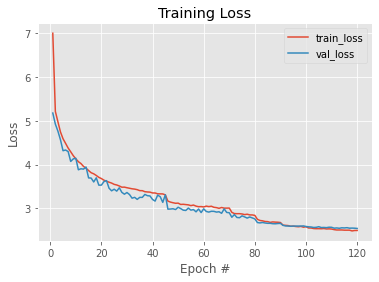

In [ ]:
import pandas as pd
hist = pd.read_csv('hist_ssdlite.csv')
import matplotlib.pyplot as plt
plt.style.use("ggplot")
plt.figure()
plt.plot(hist['epoch'], hist["train_loss"], label="train_loss")
plt.plot(hist['epoch'], hist["val_loss"], label="val_loss")
plt.title("Training Loss")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend()
plt.show()

## Evaluate

In [ ]:
def eval_APs_mAP(model, valset_loader):
    '''
    '''
    model.eval()
    detected_boxes = list()
    detected_labels = list()
    detected_scores = list()
    true_boxes = list()
    true_labels = list()
    #true_diffs = list()
    
    with torch.no_grad():
        for step, (imgs, boxes, labels, diffs) in enumerate(valset_loader):
            # move input data to GPU
            imgs = imgs.to(device)
            boxes = [b.to(device) for b in boxes]
            labels = [l.to(device) for l in labels]
            #diffs = [d.to(device) for d in diffs]

            # detect objects
            predicted_offsets, predicted_scores = model(imgs)
            batch_det_boxes, batch_det_labels, batch_det_scores = model.post_process_top_k(predicted_offsets, predicted_scores,
                                                                                      score_threshold=0.02, iou_threshold=0.45, top_k=200)
            detected_boxes.extend(batch_det_boxes)
            detected_labels.extend(batch_det_labels)
            detected_scores.extend(batch_det_scores)
            true_boxes.extend(boxes)
            true_labels.extend(labels)
            #true_diffs.extend(diffs)

        # calculate metrics value
        detected_boxes_np = [i.cpu().numpy() for i in detected_boxes]
        detected_labels_np = [i.cpu().numpy() for i in detected_labels]
        detected_scores_np = [i.cpu().numpy() for i in detected_scores]
        true_boxes_np = [i.cpu().numpy() for i in true_boxes]
        true_labels_np = [i.cpu().numpy() for i in true_labels]
        result = eval_detection_voc(detected_boxes_np, detected_labels_np, detected_scores_np, true_boxes_np, true_labels_np)
    
    return result['ap'], result['map']

In [ ]:
APs, mAP = eval_APs_mAP(ssd_lite, dataloaders['val'])
print(APs)
print(mAP)

[       nan 0.77581857 0.79981778 0.62528332 0.63079712 0.34161193
 0.75719001 0.84521685 0.83803545 0.50677108 0.63344463 0.6861428
 0.76199497 0.82698416 0.82196995 0.83060447 0.49464096 0.63587661
 0.70979963 0.88553899 0.7007706 ]
0.705415493802718


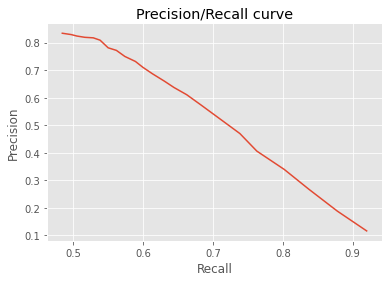

In [ ]:
precs_mean = [i.mean() for i in precs]
recs_mean = [i.mean() for i in recs]
plt.style.use("ggplot")
plt.figure()
plt.plot(recs_mean, precs_mean)
plt.title("Precision/Recall curve")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.show()

In [ ]:
threshold_id = 17
print(precs[threshold_id].mean(), recs[threshold_id].mean())
print('thresholdvalue:', np.arange(0.05, 0.50, 0.02)[threshold_id])

0.8088359912563983 0.5387135869281064
thresholdvalue: 0.39000000000000007
